# Study to Improve Number of Engagements of Social Media Posts: Fresh Tape Media

## Background

Fresh Tape Media (FTM) is a company that creates made-for-social video content for sports business brands. Currently, they are “going with their gut” when it comes to the type of content that create for a client, in hopes that the video will get a lot of views/engagements. Ultimately, I will be answering the question *What type of content sentiment generates the most favorites/engagements on Twitter?*

The value of the solution below is that FTM will be able to create content that results in the words in the hashtags/comments that correlate with the most viewership (and avoid words that negatively impact viewership). This will help drive their business because FTM will be able to make data-driven recommendations to their clients when determining the content sentiment of their material.


#### import libraries
#### twitter api credentials

In [2]:
import pandas as pd
import numpy as np
import tweepy
import twitter
import time


In [161]:
consumer_key = "gLUMKRUMrvDmu2m1XEzGq1t4e"
consumer_secret = "1N6idr96sfW1fIPYJmgcFQlWks4ZsjsvcEDbTx6S1k2qTsnlVI"
access_token = "1090700974740500480-02NLG7LJYtBL5HkAbNbwAlZaVqjeSl"
access_token_secret = "qPGV3GAvtSgHlIuPu8tdrqxWyRfG0JWcThg9y6qW6TjCs"

### credentials/authorization for tweepy (standard API)

In [162]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

## Access to Data: 

Through FTM's admin access, I was able to pull a spreadsheet of all of the FTM content that was posted to Twitter (by different professional athletes, sports leagues, sports teams, and broadcasters) within the last seven days. For each post, the spreadsheet contained the url, the number of likes/favorites, the account that posted, the number of shares/re-tweets, and the number of comments.

I used that spreadsheet to isolate the tweet ID from the URL, which I used to scrape the Standard Twitter API (which only has seven days of storage) to pull all of the replies to each tweet. From this, I had a spreadsheet of all of the replies to FTM Twitter content in the past seven days.

I also wanted to bring in high-performing and low-performing (based on number of likes) content that was NOT produced by FTM. In order to do, I scraped the Twitter API for all tweets in the last seven days from the same accounts that posted FTM content. When doing so, I also scraped the number of followers each account had. Considering the number of followers was important so that I could normalize the predictive value. For example, if one account has 78,000 followers and another has 15,000,000 followers, one would assume that the latter account would always have significantly more likes than the former. Instead of seeking to predict the number of likes/favorites, I predicted the percentage of likes (simply, the ratio of likes to the number of followers for a given account). 

Once I had that spreadsheet of non-FTM tweets by the same accounts, I limited the number of tweets to the top-two and bottom-two performers and went back to the Twitter API to scrape replies - the same way that I scraped the FTM replies. 

Finally, I concatenated both dataframes and had one large dataframe of all of the replies to both FTM and non-FTM content posted on Twitter in the last seven days.

### loading FTM dataframe

In [27]:
FTM_df1 = pd.read_excel("FTMTweets3.xlsx")
FTM_df2 = pd.read_excel("FTMTweets.xlsx")
FTM_df = pd.concat([FTM_df1, FTM_df2])

In [28]:
FTM_df.head()

,ID,Network,URL,Account,Type,Views,Shares,Likes,Dislikes,Comments,Post date,Track date,Last updated,Post caption,Thumbnail,Event tag,Partner tag,Creator tag,Filetype tag
0,2008,Twitter,/NikolaVucevic/status/1098235335132303362,NikolaVucevic,NaN,0,10,193,0,8,2019-02-20 14:58:02.004,2019-02-20 17:11:24.000,2019-02-21 01:06:36.000,🔥🔥🔥🔥 @nikebasketball https://t.co/CTgFISbgDy,NaN,NaN,NaN,NaN,NaN
1,1994,Instagram,/p/BuDEa2snJ8V/,marcelashoward,GIF,0,0,6889,0,11,2019-02-19 03:16:43.000,2019-02-20 02:00:22.003,2019-02-21 01:19:39.000,@NBA All Star Weekend Was One For The Books! T...,908d4b4efd.jpg,NaN,NaN,NaN,NaN
2,1892,Twitter,/NBAKicks/status/1097544211656790017,NBAKicks,Video,2277,10,87,0,3,2019-02-18 17:11:45.997,2019-02-18 20:17:40.004,2019-02-21 01:28:33.997,🏀🌟👟\n\n@JoelEmbiid x #NBAAllStar x #NBAKicks h...,114993e089.jpg,NaN,NaN,NaN,NaN
3,1902,Instagram,/p/BuB_G0tBEGl/,nbakicks,Video,9995,0,3603,0,21,2019-02-18 17:11:18.004,2019-02-19 18:11:24.996,2019-02-21 01:18:43.004,@joelembiid x #NBAAllStar x #NBAKicks,dd79c23cf7.jpg,NaN,NaN,NaN,NaN
4,1903,Instagram,/p/BuB9pPtBT56/,nbakicks,Video,7033,0,2824,0,7,2019-02-18 16:58:42.997,2019-02-19 18:11:32.997,2019-02-21 01:17:45.004,#NikolaJokic x #NBAAllStar x #NBAKicks,a392e1ddb0.jpg,NaN,NaN,NaN,NaN


In [29]:
FTM_df.shape

(318, 19)

In [30]:
FTM_df = FTM_df[FTM_df["Network"] == "Twitter"]

In [31]:
FTM_df.shape

(107, 19)

In [32]:
def strip_ID(url):       
    return url[-19:]

In [33]:
FTM_df["Tweet_ID"] = FTM_df["URL"].apply(strip_ID)

In [34]:
Followersdf = pd.read_csv("Twitter_Followers - Sheet1.csv")

In [35]:
Followersdf.head()

,Account,Followers,Sports League
0,NikolaVucevic,72400,NBA
1,NBAKicks,17800,NBA
2,nascar,3320000,Nascar
3,twittersports,15300000,All
4,nuggets,852000,NBA


In [36]:
FTM_df["Account"] = FTM_df["Account"].str.lower()

In [37]:
Followersdf["Account"] = Followersdf["Account"].str.lower()

In [38]:
FTM_df.head()

,ID,Network,URL,Account,Type,Views,Shares,Likes,Dislikes,Comments,Post date,Track date,Last updated,Post caption,Thumbnail,Event tag,Partner tag,Creator tag,Filetype tag,Tweet_ID
0,2008,Twitter,/NikolaVucevic/status/1098235335132303362,nikolavucevic,NaN,0,10,193,0,8,2019-02-20 14:58:02.004,2019-02-20 17:11:24.000,2019-02-21 01:06:36.000,🔥🔥🔥🔥 @nikebasketball https://t.co/CTgFISbgDy,NaN,NaN,NaN,NaN,NaN,1098235335132303362
2,1892,Twitter,/NBAKicks/status/1097544211656790017,nbakicks,Video,2277,10,87,0,3,2019-02-18 17:11:45.997,2019-02-18 20:17:40.004,2019-02-21 01:28:33.997,🏀🌟👟\n\n@JoelEmbiid x #NBAAllStar x #NBAKicks h...,114993e089.jpg,NaN,NaN,NaN,NaN,1097544211656790017
5,1891,Twitter,/nbakicks/status/1097537733155786753,nbakicks,Video,60777,164,1582,0,21,2019-02-18 16:46:01.001,2019-02-18 17:16:49.002,2019-02-21 01:00:08.004,🏀🌟👟\n\n@KDTrey5 x #NBAAllStar x #NBAKicks http...,56a2cee4b9.jpg,NaN,NaN,NaN,NaN,1097537733155786753
8,1896,Twitter,/NBAKicks/status/1097532955533160448,nbakicks,Video,29546,95,916,0,7,2019-02-18 16:27:01.999,2019-02-18 20:18:25.001,2019-02-21 01:24:30.004,🏀🌟👟\n\n@stephencurry30 x #NBAAllStar x #NBAKic...,6f23431157.jpg,NaN,NaN,NaN,NaN,1097532955533160448
11,1898,Twitter,/NBAKicks/status/1097527079569108992,nbakicks,Video,4954,9,67,0,3,2019-02-18 16:03:40.997,2019-02-18 20:18:41.003,2019-02-21 01:22:30.003,🏀🌟👟\n\n@NikolaVucevic x #NBAAllStar x #NBAKick...,fe6ee111a6.jpg,NaN,NaN,NaN,NaN,1097527079569108992


In [39]:
follower_list = []

for i in range(FTM_df.shape[0]):
    account = FTM_df["Account"].iloc[i]
    n = np.where(Followersdf["Account"] == account)
    follower_list.append(Followersdf.iloc[int(n[0]), 1])
    
    

In [40]:
FTM_df["Followers_Count"] = follower_list

In [41]:
accounts = list(FTM_df["Account"].unique())

In [42]:
FTM_df["Percent_Likes"] = FTM_df["Likes"] / FTM_df["Followers_Count"]

In [43]:
FTM_df = FTM_df[["Account", "Likes", "Tweet_ID", "Followers_Count", "Percent_Likes"]]

In [44]:
FTM_df["FTM?"] = "Yes"

In [45]:
FTM_df.to_excel("FTMTweets2.26.xlsx")

### Using Twitter API to Scrape Replies for Each Tweet

In [89]:
replies = []


for i in range(FTM_df.shape[0]):
    for tweet in tweepy.Cursor(api.search, q="to:" + FTM_df["Account"].iloc[i], since_id=FTM_df["Tweet_ID"].iloc[i], max_id=int(FTM_df["Tweet_ID"].iloc[i]) + 200000000000000, timeout=999999).items(2000):
        if tweet.in_reply_to_status_id_str == FTM_df["Tweet_ID"].iloc[i]:
            replies.append((tweet.text, tweet.in_reply_to_status_id_str))
    print("Processed Tweet ", i)
    time.sleep(900)
            

Processed Tweet  0
Processed Tweet  1
Processed Tweet  2
Processed Tweet  3
Processed Tweet  4
Processed Tweet  5
Processed Tweet  6
Processed Tweet  7
Processed Tweet  8
Processed Tweet  9
Processed Tweet  10
Processed Tweet  11
Processed Tweet  12
Processed Tweet  13
Processed Tweet  14
Processed Tweet  15
Processed Tweet  16
Processed Tweet  17
Processed Tweet  18
Processed Tweet  19
Processed Tweet  20
Processed Tweet  21
Processed Tweet  22
Processed Tweet  23
Processed Tweet  24
Processed Tweet  25
Processed Tweet  26
Processed Tweet  27
Processed Tweet  28
Processed Tweet  29
Processed Tweet  30
Processed Tweet  31
Processed Tweet  32
Processed Tweet  33
Processed Tweet  34
Processed Tweet  35
Processed Tweet  36
Processed Tweet  37
Processed Tweet  38
Processed Tweet  39
Processed Tweet  40
Processed Tweet  41
Processed Tweet  42
Processed Tweet  43
Processed Tweet  44
Processed Tweet  45
Processed Tweet  46
Processed Tweet  47
Processed Tweet  48
Processed Tweet  49
Processed 

In [91]:
len(replies)

471

In [92]:
repliesdf = pd.DataFrame(replies, columns=["Reply", "To_Tweet_ID"])

In [93]:
repliesdf.shape

(471, 2)

In [94]:
repliesdf.head()

,Reply,To_Tweet_ID
0,@NikolaVucevic @nikebasketball DRIPPY,1098235335132303362
1,@NikolaVucevic @nikebasketball Damn those are ...,1098235335132303362
2,@NikolaVucevic @nikebasketball Ils font les mê...,1098235335132303362
3,@NikolaVucevic @nikebasketball Offre moi les c...,1098235335132303362
4,@NikolaVucevic @nikebasketball Sta je to brate?,1098235335132303362


In [95]:
len(repliesdf["To_Tweet_ID"].unique())

47

In [96]:
repliesdf.to_excel("Tweet_Replies_2.xlsx")

In [3]:
repliesdf = pd.read_excel("Tweet_Replies_2.xlsx")

In [4]:
repliesdf.head()

,Reply,To_Tweet_ID
0,@NikolaVucevic @nikebasketball DRIPPY,1098235335132303362
1,@NikolaVucevic @nikebasketball Damn those are ...,1098235335132303362
2,@NikolaVucevic @nikebasketball Ils font les mê...,1098235335132303362
3,@NikolaVucevic @nikebasketball Offre moi les c...,1098235335132303362
4,@NikolaVucevic @nikebasketball Sta je to brate?,1098235335132303362


In [5]:
print(repliesdf.shape)
repliesdf.dtypes

(471, 2)


Reply          object
To_Tweet_ID     int64
dtype: object

In [8]:
repliesdf["To_Tweet_ID"] = repliesdf["To_Tweet_ID"].astype(str)

In [9]:
repliesdf.dtypes

Reply          object
To_Tweet_ID    object
dtype: object

### Using Twitter API to pull non-FTM posts based on likecount

In [163]:
other_tweets = []



for account in accounts:
    for tweet in tweepy.Cursor(api.user_timeline, screen_name=account, timeout=999999).items(20):
        if tweet.in_reply_to_user_id == None:
            other_tweets.append((tweet.user.screen_name, tweet.user.followers_count, tweet.id_str, tweet.text, tweet.favorite_count))
    print("Processed Account:", account)

            
            

Processed Account: nikolavucevic
Processed Account: nbakicks
Processed Account: nascar
Processed Account: nuggets
Processed Account: twittersports
Processed Account: rcrracing
Processed Account: nascar_xfinity
Processed Account: teamhendrick
Processed Account: atlhawks
Processed Account: wnba
Processed Account: chiney321
Processed Account: cavs


In [164]:
len(other_tweets)

210

In [165]:
dfother_tweets = pd.DataFrame(other_tweets, columns=["Account", "Followers_Count", "Tweet_ID", "Tweet_Text", "Tweet_Likes"])

In [166]:
dfother_tweets.head()

,Account,Followers_Count,Tweet_ID,Tweet_Text,Tweet_Likes
0,NikolaVucevic,73031,1100159288553758721,Bravo momci! Ogroman je ovo uspjeh za reprezen...,324
1,NikolaVucevic,73031,1098375642771529728,Welcome to Orlando @luisnani!,1043
2,NikolaVucevic,73031,1098271215477800960,We are ready for #AtletiJuve 😊! @juventusfcen ...,7930
3,NikolaVucevic,73031,1098244711557619713,RT @OrlandoMagic: Everything that happened at ...,0
4,NikolaVucevic,73031,1098235335132303362,🔥🔥🔥🔥 @nikebasketball https://t.co/CTgFISbgDy,232


In [167]:
dfother_tweets.shape

(210, 5)

In [168]:
dfother_tweets = dfother_tweets.drop_duplicates()

In [169]:
dfother_tweets.shape

(210, 5)

In [170]:
dfother_tweets["FTM?"] = "No"

In [171]:
dfother_tweets["Percent_Likes"] = dfother_tweets["Tweet_Likes"] / dfother_tweets["Followers_Count"]

In [172]:
dfother_tweets.head()

,Account,Followers_Count,Tweet_ID,Tweet_Text,Tweet_Likes,FTM?,Percent_Likes
0,NikolaVucevic,73031,1100159288553758721,Bravo momci! Ogroman je ovo uspjeh za reprezen...,324,No,0.004436
1,NikolaVucevic,73031,1098375642771529728,Welcome to Orlando @luisnani!,1043,No,0.014282
2,NikolaVucevic,73031,1098271215477800960,We are ready for #AtletiJuve 😊! @juventusfcen ...,7930,No,0.108584
3,NikolaVucevic,73031,1098244711557619713,RT @OrlandoMagic: Everything that happened at ...,0,No,0.000000
4,NikolaVucevic,73031,1098235335132303362,🔥🔥🔥🔥 @nikebasketball https://t.co/CTgFISbgDy,232,No,0.003177


In [173]:
len(dfother_tweets[dfother_tweets["Tweet_Likes"] == 0])

37

In [174]:
dfother_tweets = dfother_tweets[dfother_tweets["Tweet_Likes"] > 0]

In [176]:
accounts2 = list(dfother_tweets["Account"].unique())

In [177]:
rows_to_pull = []

for account in accounts2:
    highest = dfother_tweets[dfother_tweets["Account"] == account].sort_values("Percent_Likes")["Percent_Likes"].iloc[-1]
    second_highest = dfother_tweets[dfother_tweets["Account"] == account].sort_values("Percent_Likes")["Percent_Likes"].iloc[-2]
    lowest = dfother_tweets[dfother_tweets["Account"] == account].sort_values("Percent_Likes")["Percent_Likes"].iloc[0]
    second_lowest = dfother_tweets[dfother_tweets["Account"] == account].sort_values("Percent_Likes")["Percent_Likes"].iloc[1]
    highs_and_lows = [highest, second_highest, lowest, second_lowest]
    for num in highs_and_lows:
        i = np.where(dfother_tweets["Percent_Likes"] == num)
        rows_to_pull.append(i)
        

In [178]:
len(rows_to_pull)

48

In [179]:
import itertools

rows_to_pull = list(itertools.chain.from_iterable(rows_to_pull))

In [180]:
rows_to_pull = list(itertools.chain.from_iterable(rows_to_pull))

In [181]:
len(rows_to_pull)

49

In [182]:
best_worst_engagements = pd.DataFrame(columns=["Account", "Followers_Count", "Tweet_ID", 
                                               "Tweet_Text", "Tweet_Likes", "FTM?", "Percent_Likes"])

for i, j in zip(range(len(rows_to_pull)), rows_to_pull):
    best_worst_engagements.loc[i] = dfother_tweets.iloc[j]

In [183]:
best_worst_engagements = best_worst_engagements.drop_duplicates()

In [184]:
best_worst_engagements.shape

(49, 7)

In [186]:
best_worst_engagements.to_excel("Gen_Tweets_2.25.xlsx")

In [187]:
#overnightcode

replies = []


for i in range(best_worst_engagements.shape[0]):
    for tweet in tweepy.Cursor(api.search, q="to:" + best_worst_engagements["Account"].iloc[i], since_id=best_worst_engagements["Tweet_ID"].iloc[i], max_id=int(best_worst_engagements["Tweet_ID"].iloc[i]) + 200000000000000, timeout=999999).items(2000):
        if tweet.in_reply_to_status_id_str == best_worst_engagements["Tweet_ID"].iloc[i]:
            replies.append((tweet.text, tweet.in_reply_to_status_id_str))
    print("Processed Tweet ", i)
    time.sleep(900)
            

Processed Tweet  0
Processed Tweet  1
Processed Tweet  2
Processed Tweet  3
Processed Tweet  4
Processed Tweet  5
Processed Tweet  6
Processed Tweet  7
Processed Tweet  8
Processed Tweet  9
Processed Tweet  10
Processed Tweet  11
Processed Tweet  12
Processed Tweet  13
Processed Tweet  14
Processed Tweet  15
Processed Tweet  16
Processed Tweet  17
Processed Tweet  18
Processed Tweet  19
Processed Tweet  20
Processed Tweet  21
Processed Tweet  22
Processed Tweet  23
Processed Tweet  24
Processed Tweet  25
Processed Tweet  26
Processed Tweet  27
Processed Tweet  28
Processed Tweet  29
Processed Tweet  30
Processed Tweet  31
Processed Tweet  32
Processed Tweet  33
Processed Tweet  34
Processed Tweet  35
Processed Tweet  36
Processed Tweet  37
Processed Tweet  38
Processed Tweet  39
Processed Tweet  40
Processed Tweet  41
Processed Tweet  42
Processed Tweet  43
Processed Tweet  44
Processed Tweet  45
Processed Tweet  46
Processed Tweet  47
Processed Tweet  48


In [188]:
len(replies)

659

In [189]:
nonFTMreplies = pd.DataFrame(replies, columns=["Reply", "To_Tweet_ID"])

In [190]:
nonFTMreplies.shape

(659, 2)

In [191]:
nonFTMreplies.head()

,Reply,To_Tweet_ID
0,@NikolaVucevic @juventusfcen L,1098271215477800960
1,@NikolaVucevic @juventusfcen Come to Dallas!,1098271215477800960
2,@NikolaVucevic @juventusfcen Looks like Juvent...,1098271215477800960
3,@NikolaVucevic @juventusfcen Ljube vas Hjustonci😘,1098271215477800960
4,@NikolaVucevic @juventusfcen 🖐,1098271215477800960


In [192]:
nonFTMreplies.to_excel("NonFTM_Replies_2.25.xlsx")

GSD
+ create clear pipeline of what I do with the data (scrape data, clean data, TF/BOW, run into model, pull out features
+ write-up:
    + why TFIDF versus BOW
    + why multi-class problem
    + why specific model chosen


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import numpy as np

### Importing Original Datasets (Lists of Tweets Posted in Last 7 Days)

In [46]:
#I pulled FTM_df from Fresh Tape Media's (FTM) admin account

#I scraped Gen_df from the Twitter API, with a focus on the same accounts contained in FTM_df
#For the tweets in the Gen_df data, I pulled the two tweets for each account that showed the 
###MOST engagement and the two that showed the LEAST engagement

FTM_df = pd.read_excel("FTMTweets2.26.xlsx")
Gen_df = pd.read_excel("Gen_Tweets_2.25.xlsx")


In [47]:
FTM_df.head()

,Account,Likes,Tweet_ID,Followers_Count,Percent_Likes,FTM?
0,nikolavucevic,193,1098235335132303362,72400,0.002666,Yes
2,nbakicks,87,1097544211656790017,17800,0.004888,Yes
5,nbakicks,1582,1097537733155786753,17800,0.088876,Yes
8,nbakicks,916,1097532955533160448,17800,0.051461,Yes
11,nbakicks,67,1097527079569108992,17800,0.003764,Yes


In [48]:
Gen_df.head()

,Account,Followers_Count,Tweet_ID,Tweet_Text,Tweet_Likes,FTM?,Percent_Likes
0,NikolaVucevic,73031,1098271215477800960,We are ready for #AtletiJuve 😊! @juventusfcen ...,7930,No,0.108584
1,NikolaVucevic,73031,1097253159104323585,Hi there 🤩 @NBAAllStar #NBAAllstar2019 https:/...,7908,No,0.108283
2,NikolaVucevic,73031,1097171484899004416,"Charlotte, do you have what it takes? Show off...",48,No,0.000657
3,NikolaVucevic,73031,1097166010753445888,"Charlotte, do you have what it takes? Show off...",122,No,0.001671
4,NBAKicks,18684,1099485224231026688,🏀 @1jordanbell representing for the #Rugrats! ...,2391,No,0.127970


In [53]:
Gen_df["Account"] = Gen_df["Account"].str.lower()
FTM_df["Tweet_ID"] = FTM_df["Tweet_ID"].astype(str)
Gen_df["Tweet_ID"] = Gen_df["Tweet_ID"].astype(str)

In [54]:
FTM_df = FTM_df.reset_index(drop=True)

In [55]:
FTM_df = FTM_df.drop_duplicates(subset="Tweet_ID")

In [56]:
#aggregating the original tweet count data by account to represent it visually

account_counts = pd.DataFrame()

account_counts["Accounts"] = FTM_df["Account"].unique()

FTM_Count = []
Gen_Count = []

for account in account_counts["Accounts"]:
    FTM_Count.append(len(FTM_df[FTM_df["Account"] == account]))
    Gen_Count.append(len(Gen_df[Gen_df["Account"] == account]))

account_counts["Fresh Tape Media Content"] = FTM_Count
account_counts["Public Content"] = Gen_Count

In [57]:
account_counts = account_counts.set_index("Accounts")

account_counts.head()

,Fresh Tape Media Content,Public Content
Accounts,,
nikolavucevic,1,4
nbakicks,21,4
nascar,14,4
nuggets,1,4
twittersports,5,4


Text(0.5, 0, 'Twitter Accounts')

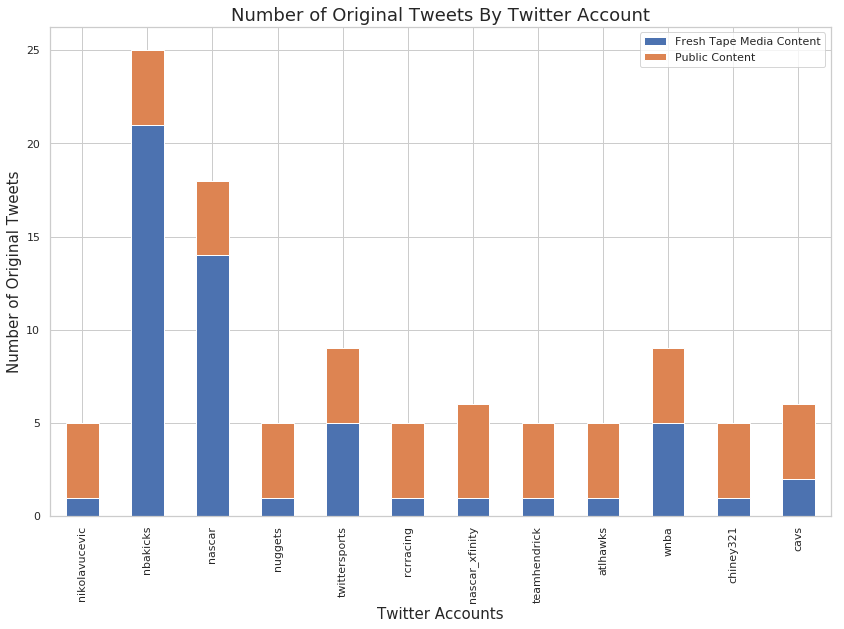

In [62]:
#plotting stacked barplot to show number of original tweets by each account; showing data from FTM and from outside
# of FTM
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(style="whitegrid")
account_counts.plot(kind="bar", stacked=True, figsize=(14,9))

plt.title("Number of Original Tweets By Twitter Account", size=18)
plt.ylabel("Number of Original Tweets", size=15)
plt.xlabel("Twitter Accounts", size=15)

### Importing/Combining Scraped Reply Data

In [63]:
#I scraped each of the three datasets loaded here from the Twitter API on three different nights. 
#The Twitter API only stores tweets and replies for 7 days, so I scraped replies to tweeets that were posted in 
# the last 7 days

repliesFTM1 = pd.read_excel("Tweet_Replies 1.xlsx")
repliesFTM2 = pd.read_excel("Tweet_Replies_2.xlsx")
repliesGen = pd.read_excel("NonFTM_Replies_2.25.xlsx")

In [64]:
#storing a column of data that indicates whether the original tweet content came from FTM or not

repliesFTM1["FTM?"] = 1
repliesFTM2["FTM?"] = 1
repliesGen["FTM?"] = 0

In [65]:
#repliesdf is a dataframe of over 1100 replies to both FTM and non-FTM twitter content as posted by different 
# athletes, sports teams, sports brands, sports leagues, or sports broadcasters

repliesdf = pd.concat([repliesFTM1, repliesFTM2, repliesGen])

In [66]:
repliesdf.shape

(1188, 3)

In [67]:
repliesdf = repliesdf.drop_duplicates()

In [68]:
repliesdf.shape

(1127, 3)

In [69]:
repliesdf.dtypes

Reply          object
To_Tweet_ID     int64
FTM?            int64
dtype: object

In [70]:
repliesdf["To_Tweet_ID"] = repliesdf["To_Tweet_ID"].astype(str)

In [71]:
repliesdf = repliesdf.reset_index(drop=True)

In [72]:
repliesdf.shape

(1127, 3)

## Feature Engineering Using NLP - Bag of Words vs. TF-IDF

When doing feature engineering using natural language processing, I tried two approaches and created two different dataframes: 1. bag of words  2. term frequency-inverse document frequency (TF-IDF). 

In the first approach, bag of words, I pulled all of the most frequent words from the set of replies to each tweet. Then I created a dataframe that all of the most frequent words ("bag of words") and included a count of each word for each reply. Once I had that dataframe, I aggregated the word counts by combining them for each tweet ID. 

In the second approach, TF-IDF, I used the TFIDFVectorizer to pull out a list of words that included words that appeared more than once in the body of text and did not occur in more than half of the replies. From there, I fit the vectorizer to the replies data and got the TF-IDF vector for the presence of each word in each reply. Once I had that dataframe, I again aggregated the vectors by combining them for each tweet ID. 

I created test and train sets from BOTH the aggregated bag of words dataframe and the TF-IDF dataframe. I ran supervised models and unsupervised clustering on both datasets and found better accuracy on the bag of words data, so that is what is included in the solution below.

### Bag of Words Approach

In [73]:
import spacy
from collections import Counter
import itertools

In [74]:
nlp = spacy.load("en")

In [75]:
def wrap_spacy(reply):
    
    return nlp(reply)

In [76]:
repliesdf["NLP_Reply"] = repliesdf["Reply"].apply(wrap_spacy)

In [77]:
repliesdf.head()

,Reply,To_Tweet_ID,FTM?,NLP_Reply
0,@NikolaVucevic @nikebasketball Sta je to brate?,1098235335132303362,1,"(@NikolaVucevic, @nikebasketball, Sta, je, to,..."
1,@NikolaVucevic @nikebasketball 💧💧💧,1098235335132303362,1,"(@NikolaVucevic, @nikebasketball, 💧, 💧, 💧)"
2,@NikolaVucevic @nikebasketball Shoe game strong!,1098235335132303362,1,"(@NikolaVucevic, @nikebasketball, Shoe, game, ..."
3,@NikolaVucevic @nikebasketball #MFFL,1098235335132303362,1,"(@NikolaVucevic, @nikebasketball, #, MFFL)"
4,@NBAKicks @NBA @KDTrey5 https://t.co/4LtK8FIv8Q,1097537733155786753,1,"(@NBAKicks, @NBA, @KDTrey5, https://t.co/4LtK8..."


In [78]:
def pull_tweet_indices(tweet_id):
    indices_array = np.where(repliesdf["To_Tweet_ID"] == tweet_id)
    return list(indices_array[0])

    

In [79]:
#defining function to pull a set of 35 common words from each set of replies to a given tweet

def bag_of_words(tweet_id):
    all_words = []

    indices = pull_tweet_indices(tweet_id)
    
    for i in indices:
        some_words = [w for w in repliesdf["NLP_Reply"].iloc[indices][i]]
        all_words.append(some_words)
    all_words_joined = list(itertools.chain.from_iterable(all_words))
    toks = [token.lemma_ for token in all_words_joined if not (token.is_punct or token.is_stop)]
    
    return [item[0] for item in Counter(toks).most_common(35)]

In [80]:
#combining all 35-word sets into one common set of words

common_words = []

for j in range(len(repliesdf["To_Tweet_ID"].unique())):
    bow = bag_of_words(repliesdf["To_Tweet_ID"].unique()[j])
    common_words.append(bow)

common_words_joined = list(itertools.chain.from_iterable(common_words))
common_frequent_words = set(common_words_joined)

In [82]:
#defining a function that counts how many times each of the common words shows up in a given reply

def bow_features(tweets, common_words):
    
    df = pd.DataFrame(columns=common_words)
    df['Reply'] = tweets.iloc[:, 3]
    df['To_Tweet_ID'] = tweets.iloc[:, 1]
    df.loc[:, common_words] = 0
    df.head()
    
    for i, tweet in enumerate(df['Reply']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        
        
        words = [w for w in tweet]
        toks = [token.lemma_ for token in words if not (token.is_punct or token.is_stop)]
    
        
        
        # Populate the row with word counts.
        for tok in toks:
           # df.loc[i, tok] += 1
            try:
                df.loc[i,tok] +=1
            except KeyError:
                df.loc[i,tok] = 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 50 == 0:
            print("Processing row {}".format(i))
            
    return df

In [83]:
word_counts = bow_features(repliesdf, common_frequent_words)

Processing row 0
Processing row 50
Processing row 100
Processing row 150
Processing row 200
Processing row 250
Processing row 300
Processing row 350
Processing row 400
Processing row 450
Processing row 500
Processing row 550
Processing row 600
Processing row 650
Processing row 700
Processing row 750
Processing row 800
Processing row 850
Processing row 900
Processing row 950
Processing row 1000
Processing row 1050
Processing row 1100


In [84]:
word_counts.head()

,well,,https://t.co/o4aftsjbum,@disupdat,incident,autograph,emoji,intro,rush,what,...,comeback,https://t.co/jvitsmguyd,jeez,vamo,porra,https://t.co/wryutafljq,please,bed,confused,table
0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
word_counts.shape

(1127, 2395)

In [86]:
del word_counts["Reply"]
del word_counts["To_Tweet_ID"]

In [87]:
word_counts.shape

(1127, 2393)

In [88]:
word_counts["Reply"] = repliesdf["NLP_Reply"]
word_counts["To_Tweet_ID"] = repliesdf["To_Tweet_ID"]
word_counts["FTM?"] = repliesdf["FTM?"]

In [89]:
word_counts.head()

,well,,https://t.co/o4aftsjbum,@disupdat,incident,autograph,emoji,intro,rush,what,...,vamo,porra,https://t.co/wryutafljq,please,bed,confused,table,Reply,To_Tweet_ID,FTM?
0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(@NikolaVucevic, @nikebasketball, Sta, je, to,...",1098235335132303362,1
1,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(@NikolaVucevic, @nikebasketball, 💧, 💧, 💧)",1098235335132303362,1
2,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(@NikolaVucevic, @nikebasketball, Shoe, game, ...",1098235335132303362,1
3,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(@NikolaVucevic, @nikebasketball, #, MFFL)",1098235335132303362,1
4,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(@NBAKicks, @NBA, @KDTrey5, https://t.co/4LtK8...",1097537733155786753,1


In [90]:
#aggregating the bag of words data represent it visually


words = []
count = []

for word in word_counts.loc[:, ~word_counts.columns.isin(["Reply", "To_Tweet_ID", "FTM?"])].columns:
    words.append(word)
    count.append(sum(word_counts[word]))
    
total_word_counts = pd.DataFrame()
total_word_counts["word"] = words
total_word_counts["count"] = count
total_word_counts = total_word_counts.sort_values("count", ascending=False)


Text(0.5, 0, 'Word')

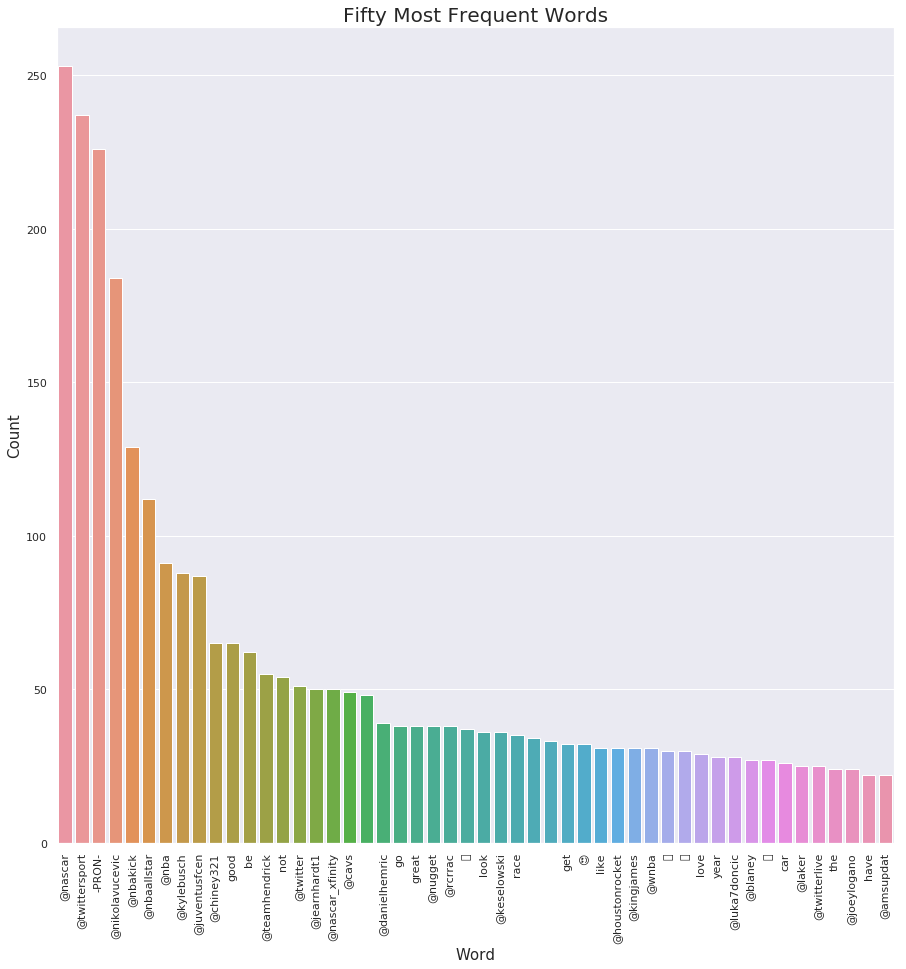

In [91]:
import seaborn as sns

sns.set(style="whitegrid")
sns.set(rc={"figure.figsize": (15,15)})
ax = sns.barplot(x=total_word_counts["word"][:50], y=total_word_counts["count"][:50], data=total_word_counts)
ax.set_xticklabels(total_word_counts["word"][:50], rotation=90)
ax.set_title("Fifty Most Frequent Words", size=20)
ax.set_ylabel("Count", size=15)
ax.set_xlabel("Word", size=15)

#### Aggregate BOW data by tweet

In [92]:
len(word_counts["To_Tweet_ID"].unique())

85

In [93]:
aggregated_word_counts = pd.DataFrame(columns=common_frequent_words)

for i, ID in enumerate(word_counts["To_Tweet_ID"].unique()):
    indices = list(np.where(word_counts["To_Tweet_ID"] == ID)[0])
    sums = word_counts.iloc[indices].sum()
    aggregated_word_counts.loc[i] = sums

aggregated_word_counts["To_Tweet_ID"] = word_counts["To_Tweet_ID"].unique()

In [94]:
aggregated_word_counts.shape

(85, 1083)

In [95]:
aggregated_word_counts.head()

,well,,https://t.co/o4aftsjbum,@disupdat,incident,autograph,emoji,intro,rush,what,...,frangin,2019,@russwest44,he,치치치치,son,draft,but,mano,To_Tweet_ID
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1098235335132303362
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1097537733155786753
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1097532955533160448
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1097517678200270849
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1097498653986603008


In [96]:
aggregated_word_counts["To_Tweet_ID"] = word_counts["To_Tweet_ID"].unique()

### Preparing the Data for Modeling

**BOW Features**

In [97]:
aggregated_word_counts["To_Tweet_ID"] = word_counts["To_Tweet_ID"].unique()

In [98]:
#adding a percent_likes column to the aggregated BOW dataframe because that is the value I am predicting

aggregated_word_counts["Total_Followers"] = None
aggregated_word_counts["Num_Likes"] = None
aggregated_word_counts["Percent_Likes"] = None
aggregated_word_counts.head()

,well,,https://t.co/o4aftsjbum,@disupdat,incident,autograph,emoji,intro,rush,what,...,he,치치치치,son,draft,but,mano,To_Tweet_ID,Total_Followers,Num_Likes,Percent_Likes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1098235335132303362,None,None,None
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1097537733155786753,None,None,None
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1097532955533160448,None,None,None
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1097517678200270849,None,None,None
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1097498653986603008,None,None,None


In [99]:
aggregated_word_counts.shape

(85, 1086)

In [100]:
#bringing in number of likes, followers, and percent_liked

likes_list = []

for i in range(aggregated_word_counts.shape[0]):
    ID = aggregated_word_counts["To_Tweet_ID"].iloc[i]
    if ID in list(FTM_df["Tweet_ID"]):
        n = np.where(FTM_df["Tweet_ID"] == ID)
        likes_list.append(FTM_df.iloc[int(n[0]), 1])
    elif ID in list(Gen_df["Tweet_ID"]):
        n = np.where(Gen_df["Tweet_ID"] == ID)
        likes_list.append(Gen_df.iloc[int(n[0]), 4])
    else:
        likes_list.append("Not found")
        
aggregated_word_counts["Num_Likes"] = likes_list

In [86]:
aggregated_word_counts.head()

,🤙,🇺,vucevic,now,describe,powerful,dope,no.1,🤤,@alexbowman88,...,https://t.co/vpo5sjkd5f,@jearnhardt1,racing,yeah,jimmie,😅,To_Tweet_ID,Total_Followers,Num_Likes,Percent_Likes
0,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,...,NaN,NaN,0,0,0,NaN,1098235335132303362,None,193,None
1,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,...,NaN,NaN,0,0,0,NaN,1097537733155786753,None,1582,None
2,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,...,NaN,NaN,0,0,0,NaN,1097532955533160448,None,916,None
3,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,...,NaN,NaN,0,0,0,NaN,1097517678200270849,None,972,None
4,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,...,NaN,NaN,0,0,0,NaN,1097498653986603008,None,966,None


In [101]:
followers_list = []

for i in range(aggregated_word_counts.shape[0]):
    ID = aggregated_word_counts["To_Tweet_ID"].iloc[i]
    if ID in list(FTM_df["Tweet_ID"]):
        n = np.where(FTM_df["Tweet_ID"] == ID)
        followers_list.append(FTM_df.iloc[int(n[0]), 3])
    elif ID in list(Gen_df["Tweet_ID"]):
        n = np.where(Gen_df["Tweet_ID"] == ID)
        followers_list.append(Gen_df.iloc[int(n[0]), 1])
    else:
        followers_list.append("Not found")
        
aggregated_word_counts["Total_Followers"] = followers_list
    
    

        
    

In [102]:
aggregated_word_counts.head()

,well,,https://t.co/o4aftsjbum,@disupdat,incident,autograph,emoji,intro,rush,what,...,he,치치치치,son,draft,but,mano,To_Tweet_ID,Total_Followers,Num_Likes,Percent_Likes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1098235335132303362,72400,193,None
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1097537733155786753,17800,1582,None
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1097532955533160448,17800,916,None
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1097517678200270849,17800,972,None
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1097498653986603008,17800,966,None


In [103]:
aggregated_word_counts["Percent_Likes"] = aggregated_word_counts["Num_Likes"] / aggregated_word_counts["Total_Followers"]


In [104]:
aggregated_word_counts.head()

,well,,https://t.co/o4aftsjbum,@disupdat,incident,autograph,emoji,intro,rush,what,...,he,치치치치,son,draft,but,mano,To_Tweet_ID,Total_Followers,Num_Likes,Percent_Likes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1098235335132303362,72400,193,0.002666
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1097537733155786753,17800,1582,0.088876
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1097532955533160448,17800,916,0.051461
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1097517678200270849,17800,972,0.054607
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1097498653986603008,17800,966,0.054270


In [105]:
aggregated_word_counts = aggregated_word_counts.fillna(0)


In [106]:
#setting up training and test sets for both dataframes (word counts and word vectors)
offset_c = int(aggregated_word_counts.shape[0] / 2)
df_train_counts = aggregated_word_counts.iloc[:offset_c]
df_test_counts = aggregated_word_counts.iloc[offset_c:]

xc_train, yc_train = df_train_counts.loc[:, ~df_train_counts.columns.isin(["To_Tweet_ID", "Total_Followers", 
                                                       "Num_Likes", "Percent_Likes"])], df_train_counts["Percent_Likes"]
xc_test, yc_test = df_test_counts.loc[:, ~df_test_counts.columns.isin(["To_Tweet_ID", "Total_Followers", 
                                                       "Num_Likes", "Percent_Likes"])], df_test_counts["Percent_Likes"]


### Running word counts and word vectors through multiple supervised learning models

In [107]:
#KNN Regression

#word counts
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

neighbors = KNeighborsRegressor(n_neighbors=10, weights="distance")
neighbors.fit(xc_train, yc_train)
yc_pred_train = neighbors.predict(xc_train)

print("KNN Train Word Counts: MAE, MSE, RMSE")
print(metrics.mean_absolute_error(yc_train, yc_pred_train))
print(metrics.mean_squared_error(yc_train, yc_pred_train))
print(np.sqrt(metrics.mean_squared_error(yc_train, yc_pred_train)))

yc_pred_test = neighbors.predict(xc_test)

print("\nKNN Test Word Counts: MAE, MSE, RMSE")
print(metrics.mean_absolute_error(yc_test, yc_pred_test))
print(metrics.mean_squared_error(yc_test, yc_pred_test))
print(np.sqrt(metrics.mean_squared_error(yc_test, yc_pred_test)))


KNN Train Word Counts: MAE, MSE, RMSE
0.0
0.0
0.0

KNN Test Word Counts: MAE, MSE, RMSE
0.024038046077317996
0.0008329035052508493
0.028860067658459315


In [108]:
#Linear regression
from sklearn.linear_model import LinearRegression

#word counts
linear = LinearRegression(fit_intercept=True)
linear.fit(xc_train, yc_train)
yc_pred_train = linear.predict(xc_train)

print("Linear Regression Train Word Counts: MAE, MSE, RMSE")
print(metrics.mean_absolute_error(yc_train, yc_pred_train))
print(metrics.mean_squared_error(yc_train, yc_pred_train))
print(np.sqrt(metrics.mean_squared_error(yc_train, yc_pred_train)))

yc_pred_test = linear.predict(xc_test)

print("\nLinear Regression Test Word Counts: MAE, MSE, RMSE")
print(metrics.mean_absolute_error(yc_test, yc_pred_test))
print(metrics.mean_squared_error(yc_test, yc_pred_test))
print(np.sqrt(metrics.mean_squared_error(yc_test, yc_pred_test)))




Linear Regression Train Word Counts: MAE, MSE, RMSE
1.0289315584438157e-16
2.473018533857078e-32
1.5725833948815174e-16

Linear Regression Test Word Counts: MAE, MSE, RMSE
0.04967783683748322
0.013285807422477099
0.11526407689508947


In [109]:
# Random Forest

#word counts
from sklearn import ensemble

rfc = ensemble.RandomForestRegressor()

rfc.fit(xc_train, yc_train)
yc_pred_train = rfc.predict(xc_train)

print("Random Forest Train Word Counts: MAE, MSE, RMSE")
print(metrics.mean_absolute_error(yc_train, yc_pred_train))
print(metrics.mean_squared_error(yc_train, yc_pred_train))
print(np.sqrt(metrics.mean_squared_error(yc_train, yc_pred_train)))

yc_pred_test = rfc.predict(xc_test)

print("\nRandom Forest Test Word Counts: MAE, MSE, RMSE")
print(metrics.mean_absolute_error(yc_test, yc_pred_test))
print(metrics.mean_squared_error(yc_test, yc_pred_test))
print(np.sqrt(metrics.mean_squared_error(yc_test, yc_pred_test)))


Random Forest Train Word Counts: MAE, MSE, RMSE
0.005121653738968165
9.155688153624143e-05
0.00956853601844302

Random Forest Test Word Counts: MAE, MSE, RMSE
0.00961589300655587
0.00047225055377704317
0.021731326553550364


/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Percent_Like as A Classification Problem

After running various supervised learning models on the bag of words data as a regression model, the results were inconsistent and had high mean average errors (MAE). As such, I decided to change the problem into a classification problem. Because of the range in percent likes, I classified all tweets below the median percent likes as "Below Average," all tweets between the median and the mean as "Average," and all tweets above the mean of percent likes as "Above Average."

Now that I had a classification problem on my hands, I tried fitting and predicting the data with a decision tree, logistic regression (both lasso and ridge regression), a KNN classifier, and a Random Forest classifier.

**Decision Trees**

In [110]:
yc_test_class = []

for y in yc_test:
    if y < yc_test.median():
        yc_test_class.append("Below_Average")
    elif (y > yc_test.median()) and (y < yc_test.mean()):
        yc_test_class.append("Average")
    elif y > yc_test.mean():
        yc_test_class.append("Above_Average")
    else:
        yc_test_class.append("Average")
        
yc_train_class = []

for y in yc_train:
    if y < yc_train.median():
        yc_train_class.append("Below_Average")
    elif (y > yc_train.median()) and (y < yc_train.mean()):
        yc_train_class.append("Average")
    elif y > yc_train.mean():
        yc_train_class.append("Above_Average")
    else:
        yc_train_class.append("Average")
        

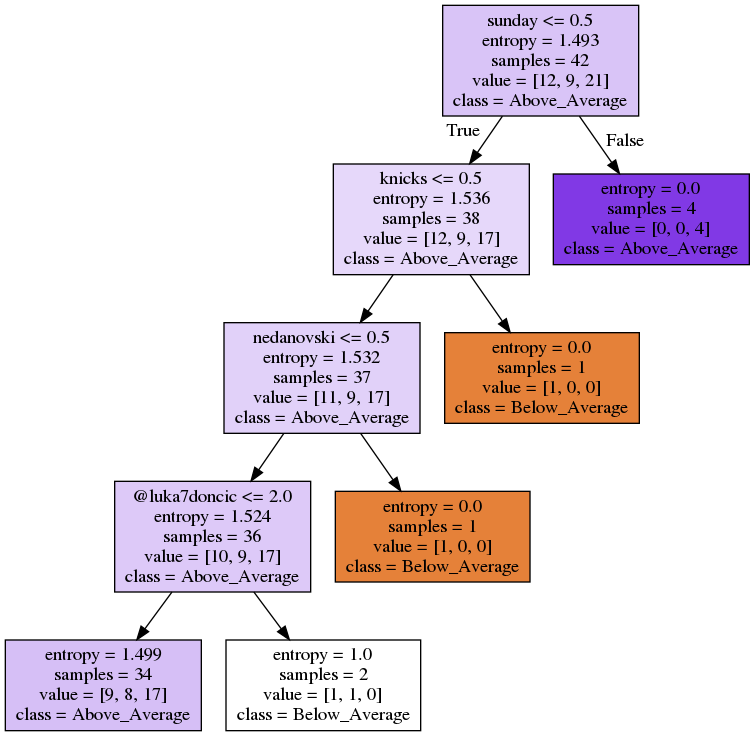

In [111]:
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz
from sklearn import tree
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import ensemble

decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=2,
    max_depth=4
)
model = decision_tree.fit(xc_train, yc_train_class)

yc_pred_test = model.predict(xc_test)

# Render our tree.
dot_data = tree.export_graphviz(
    model, out_file=None,
    feature_names=xc_train.columns,
    class_names=["Below_Average", "Average", "Above_Average"],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [112]:
cross = pd.DataFrame()

cross["Actual"] = yc_test_class
cross["Prediction"] = yc_pred_test

pd.crosstab(cross["Actual"], cross["Prediction"])

Prediction,Above_Average,Below_Average
Actual,,
Above_Average,1,6
Average,0,15
Below_Average,1,20


In [113]:
print("Percent Accuracy of Default Decision Tree:", (yc_test_class == yc_pred_test).sum() / len(yc_test_class))

Percent Accuracy of Default Decision Tree: 0.4883720930232558


In [114]:
# optimizing decision tree

dec_tree_accuracy = []
Nums = []

for f in range(2,7):
    for d in range(2,15):
        decision_tree = tree.DecisionTreeClassifier(
            criterion='entropy', 
            max_features=f,
            max_depth=d
        )
        model = decision_tree.fit(xc_train, yc_train_class)
        yc_pred_test = model.predict(xc_test)
        dec_tree_accuracy.append((yc_test_class == yc_pred_test).sum() / len(yc_test_class))
        Nums.append((f, d))

best_accuracy = max(dec_tree_accuracy)
index = dec_tree_accuracy.index(best_accuracy)
optimized_f, optimized_d = Nums[index]

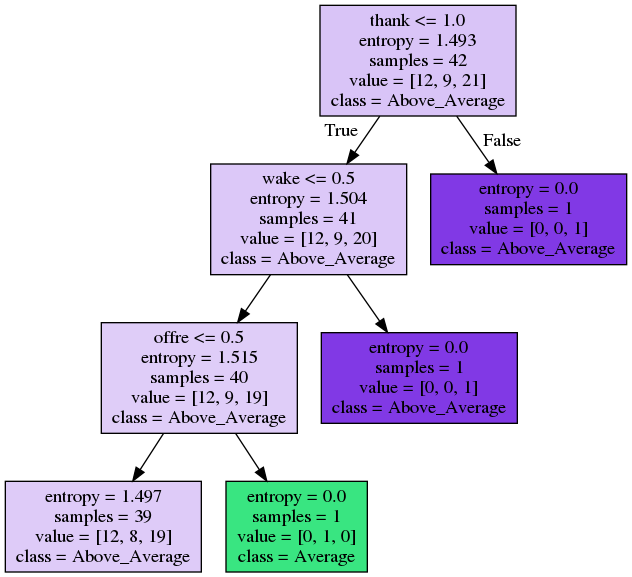

In [115]:
#optimized decision tree

decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=optimized_f,
    max_depth=optimized_d
)
model = decision_tree.fit(xc_train, yc_train_class)

yc_pred_test = model.predict(xc_test)

# Render our tree.
dot_data = tree.export_graphviz(
    model, out_file=None,
    feature_names=xc_train.columns,
    class_names=["Below_Average", "Average", "Above_Average"],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [116]:
cross = pd.DataFrame()

cross["Actual"] = yc_test_class
cross["Prediction"] = yc_pred_test


In [117]:
print("Percent Accuracy of Optimized Decision Tree:", (yc_test_class == yc_pred_test).sum() / len(yc_test_class))

Percent Accuracy of Optimized Decision Tree: 0.4883720930232558


Text(0.5, 1.0, 'Cross-tabulation Decision Tree Outcomes')

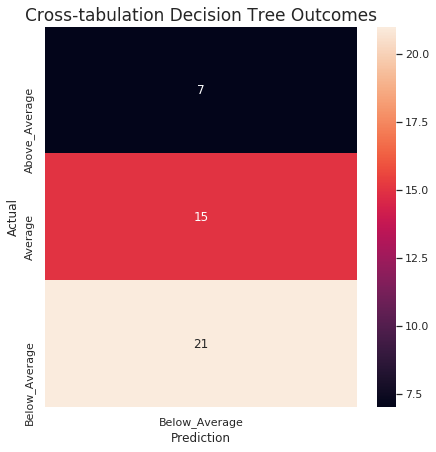

In [118]:
sns.set(rc={'figure.figsize':(7,7)})
ax = sns.heatmap(pd.crosstab(cross["Actual"], cross["Prediction"]), annot=True)
ax.set_title("Cross-tabulation Decision Tree Outcomes", size=17)

In [119]:
#KNN Classifier 

#word counts
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

neighbors = KNeighborsClassifier(n_neighbors=7, weights="distance")
neighbors.fit(xc_train, yc_train_class)
yc_pred_train = neighbors.predict(xc_train)


yc_pred_test = neighbors.predict(xc_test)

print("Word Counts:\n")
print("Percent Accuracy of Training KNN Classifier:", (yc_train_class == yc_pred_train).sum() / len(yc_train_class))
print("Percent Accuracy of Test KNN Classifier:", (yc_test_class == yc_pred_test).sum() / len(yc_test_class))


Word Counts:

Percent Accuracy of Training KNN Classifier: 1.0
Percent Accuracy of Test KNN Classifier: 0.4186046511627907


In [120]:
#Logistic regression - Ridge regression

from sklearn.linear_model import LogisticRegression

#word counts
logist = LogisticRegression(penalty="l2", fit_intercept=True)
logist.fit(xc_train, yc_train_class)
yc_pred_train = logist.predict(xc_train)

yc_pred_test = logist.predict(xc_test)

print("Word Counts:\n")
print("Percent Accuracy of Training Logistic (ridge) Regression:", (yc_train_class == yc_pred_train).sum() / len(yc_train_class))
print("Percent Accuracy of Test Logistic (ridge) Regression:", (yc_test_class == yc_pred_test).sum() / len(yc_test_class))


Word Counts:

Percent Accuracy of Training Logistic (ridge) Regression: 1.0
Percent Accuracy of Test Logistic (ridge) Regression: 0.5348837209302325


/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [121]:
#Logistic regression - Lasso regression

from sklearn.linear_model import LogisticRegression

#word counts
logist = LogisticRegression(penalty="l1", fit_intercept=True)
logist.fit(xc_train, yc_train_class)
yc_pred_train = logist.predict(xc_train)

yc_pred_test = logist.predict(xc_test)

print("Word Counts:\n")
print("Percent Accuracy of Training Logistic (lasso) Regression:", (yc_train_class == yc_pred_train).sum() / len(yc_train_class))
print("Percent Accuracy of Test Logistic (lasso) Regression:", (yc_test_class == yc_pred_test).sum() / len(yc_test_class))


Word Counts:

Percent Accuracy of Training Logistic (lasso) Regression: 1.0
Percent Accuracy of Test Logistic (lasso) Regression: 0.5116279069767442


/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [122]:
# Random Forest

#word counts
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier()
rfc.fit(xc_train, yc_train_class)
yc_pred_train = rfc.predict(xc_train)
yc_pred_test = rfc.predict(xc_test)

print("Word Counts:\n")
print("Percent Accuracy of Training Random Forest:", (yc_train_class == yc_pred_train).sum() / len(yc_train_class))
print("Percent Accuracy of Test Random Forest:", (yc_test_class == yc_pred_test).sum() / len(yc_test_class))


Word Counts:

Percent Accuracy of Training Random Forest: 1.0
Percent Accuracy of Test Random Forest: 0.4883720930232558


/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Tuning Logistic Regression (Lasso)

The model that had the best outcomes when predicting class and avoided overfitting was logistic (lasso) regression. Below, I try tuning the hyperparameters of that model to optimize the predictive power of the model.

In [123]:
#Tuning hyperparameters Logistic (Lasso) Regression


#word counts
lambdas = [.02, .05, .10, .15, .25, .35, .5, .55, .65, .75, .95, 1, 1.1, 1.3]


for lam in lambdas:
    lass = LogisticRegression(C=1/lam, fit_intercept=True, penalty="l1")
    lass.fit(xc_train, yc_train_class)
    yc_pred_train = lass.predict(xc_train)
    yc_pred_test = lass.predict(xc_test)

    print("Word Counts: ", lam)
    print("Percent Accuracy of Training Logistic (lasso) Regression:", (yc_train_class == yc_pred_train).sum() / len(yc_train_class))
    print("Percent Accuracy of Test Logistic (lasso) Regression:", (yc_test_class == yc_pred_test).sum() / len(yc_test_class))

    

Word Counts:  0.02
Percent Accuracy of Training Logistic (lasso) Regression: 1.0
Percent Accuracy of Test Logistic (lasso) Regression: 0.5581395348837209
Word Counts:  0.05
Percent Accuracy of Training Logistic (lasso) Regression: 1.0
Percent Accuracy of Test Logistic (lasso) Regression: 0.5348837209302325
Word Counts:  0.1
Percent Accuracy of Training Logistic (lasso) Regression: 1.0
Percent Accuracy of Test Logistic (lasso) Regression: 0.5116279069767442
Word Counts:  0.15
Percent Accuracy of Training Logistic (lasso) Regression: 1.0
Percent Accuracy of Test Logistic (lasso) Regression: 0.5116279069767442
Word Counts:  0.25
Percent Accuracy of Training Logistic (lasso) Regression: 1.0
Percent Accuracy of Test Logistic (lasso) Regression: 0.4883720930232558
Word Counts:  0.35
Percent Accuracy of Training Logistic (lasso) Regression: 1.0
Percent Accuracy of Test Logistic (lasso) Regression: 0.4883720930232558
Word Counts:  0.5
Percent Accuracy of Training Logistic (lasso) Regression: 1

/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/jtillis0317/anaconda3/lib/python3.7/site-package

In [124]:
#using optimized logistic (lasso) regression on word counts

lass = LogisticRegression(C=1/1.1, fit_intercept=True, penalty="l1")
lass.fit(xc_train, yc_train_class)
yc_pred_train = lass.predict(xc_train)
yc_pred_test = lass.predict(xc_test)

print("Word Counts: ", lam)
print("Percent Accuracy of Training Logistic (lasso) Regression:", (yc_train_class == yc_pred_train).sum() / len(yc_train_class))
print("Percent Accuracy of Test Logistic (lasso) Regression:", (yc_test_class == yc_pred_test).sum() / len(yc_test_class))


Word Counts:  1.3
Percent Accuracy of Training Logistic (lasso) Regression: 1.0
Percent Accuracy of Test Logistic (lasso) Regression: 0.5348837209302325


/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Text(0.5, 1.0, 'Cross-tabulation of Logistic (Lasso) Regression Accuracy')

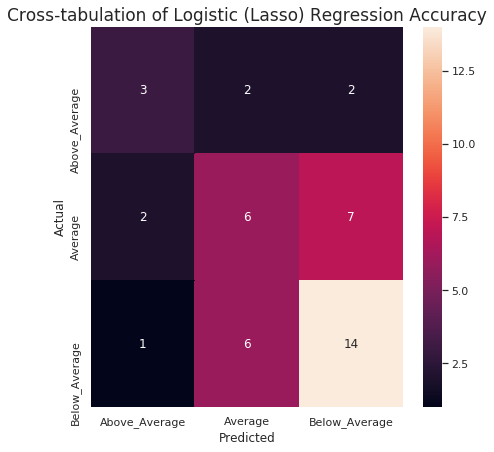

In [125]:
Lassodf = pd.DataFrame()

Lassodf["Actual"] = yc_test_class
Lassodf["Predicted"] = yc_pred_test

sns.set(rc={'figure.figsize':(7,7)})
ax = sns.heatmap(pd.crosstab(Lassodf["Actual"], Lassodf["Predicted"]), annot=True)
ax.set_title("Cross-tabulation of Logistic (Lasso) Regression Accuracy", size=17)

## Clustering

After landing on logistic (lasso) regression as the classifying model with the most predictive power, I wanted to see how looking at the problem as an unsupervised problem might improve results. As you'll see below, all three types of clustering that I try (k-means, meanshift, spectral) got poor predictive classification results.

In [126]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering


In [127]:
cluster_labels = pd.DataFrame()

In [128]:
#k-means
kmeans = KMeans(n_clusters=3)
kmeans = kmeans.fit(xc_train)
kmlabels = kmeans.labels_
cluster_labels["KMeans"] = kmlabels

In [129]:
#meanshift

bandwidth = estimate_bandwidth(xc_train, quantile=.5)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms = ms.fit(xc_train)
mslabels = ms.labels_
cluster_labels["Meanshift"] = mslabels

In [130]:
#spectral clustering
sc3 = SpectralClustering(n_clusters=3)
sc3 = sc3.fit(xc_train)
sc3labels = sc3.labels_
cluster_labels["Spectral"] = sc3labels

/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/cluster/spectral.py:268: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  n_init=n_init)


In [131]:
cluster_labels["Actual"] = yc_train_class

In [132]:
cluster_labels.head()

,KMeans,Meanshift,Spectral,Actual
0,1,0,0,Average
1,1,0,0,Above_Average
2,1,0,0,Above_Average
3,1,0,0,Above_Average
4,1,0,0,Above_Average


Text(0.5, 1.0, 'Cross-tabulation of K-Means Clustering')

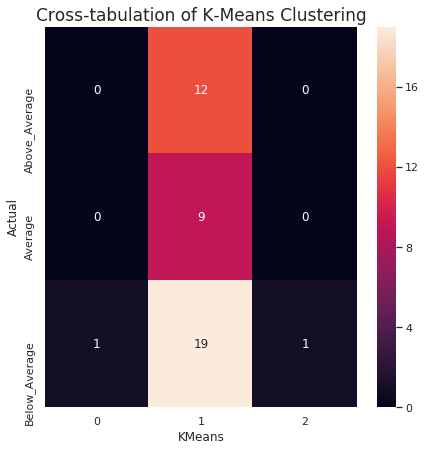

In [133]:
sns.set(rc={'figure.figsize':(7,7)})
ax = sns.heatmap(pd.crosstab(cluster_labels["Actual"], cluster_labels["KMeans"]), annot=True)
ax.set_title("Cross-tabulation of K-Means Clustering", size=17)

Text(0.5, 1.0, 'Cross-tabulation of Spectral Clustering')

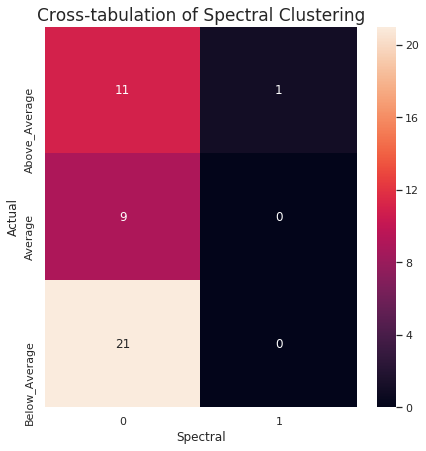

In [136]:
sns.set(rc={'figure.figsize':(7,7)})
ax = sns.heatmap(pd.crosstab(cluster_labels["Actual"], cluster_labels["Spectral"]), annot=True)
ax.set_title("Cross-tabulation of Spectral Clustering", size=17)

Text(0.5, 1.0, 'Cross-tabulation of Meanshift Clustering')

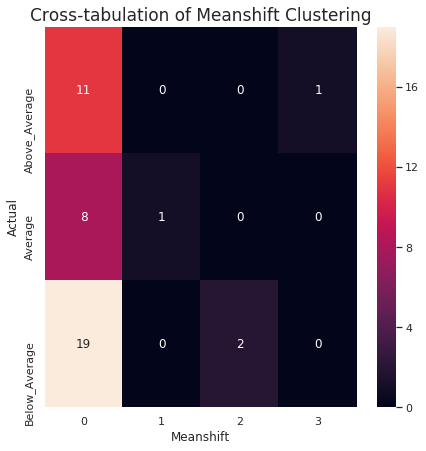

In [137]:
sns.set(rc={'figure.figsize':(7,7)})
ax = sns.heatmap(pd.crosstab(cluster_labels["Actual"], cluster_labels["Meanshift"]), annot=True)
ax.set_title("Cross-tabulation of Meanshift Clustering", size=17)

## Exploring Explanatory Power of Logistic (Lasso) Regression

After scraping the data, feature engineering based on bag of words, landing on logistic (lasso) regression as the model with the best predictive power, I wanted to look at feature importance within the model's prediction. In doing so, I could deliver to FTM words/features to aim for in their content and words/features to avoid.

In [139]:
lass = LogisticRegression(C=1/1.1, fit_intercept=True, penalty="l1", multi_class="ovr")
lass.fit(xc_train, yc_train_class)
yc_pred_train = lass.predict(xc_train)
yc_pred_test = lass.predict(xc_test)

weights = lass.coef_

/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [140]:
weights = weights * 100000000

In [141]:
weightsdf = pd.DataFrame(weights, columns=xc_test.columns)

In [142]:
weightsdf

,well,,https://t.co/o4aftsjbum,@disupdat,incident,autograph,emoji,intro,rush,what,...,basket,frangin,2019,@russwest44,he,치치치치,son,draft,but,mano
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [143]:
weightsdf = weightsdf.T

weightsdf.head()


,0,1,2
well,0.0,0.0,0.0
,0.0,0.0,0.0
https://t.co/o4aftsjbum,0.0,0.0,0.0
@disupdat,0.0,0.0,0.0
incident,0.0,0.0,0.0


In [144]:
weightsdf.columns = lass.classes_
weightsdf.head()

,Above_Average,Average,Below_Average
well,0.0,0.0,0.0
,0.0,0.0,0.0
https://t.co/o4aftsjbum,0.0,0.0,0.0
@disupdat,0.0,0.0,0.0
incident,0.0,0.0,0.0


In [145]:
weightsdf.sort_values("Above_Average")

,Above_Average,Average,Below_Average
@mac11,-7.888077e+07,7.632076e+07,0.000000e+00
@nascar,-3.000353e+07,-6.081586e+07,5.376212e+07
@twittersport,-2.024157e+07,-5.100000e+07,5.464763e+07
@wnba,-1.491436e+07,0.000000e+00,0.000000e+00
@chiney321,-1.222684e+07,0.000000e+00,8.043854e+07
@nikolavucevic,-6.126346e+06,3.030271e+07,-2.610514e+07
@teamhendrick,-3.762956e+06,1.891464e+07,-1.525735e+07
congrat,0.000000e+00,0.000000e+00,0.000000e+00
dem,0.000000e+00,0.000000e+00,0.000000e+00
bring,0.000000e+00,0.000000e+00,0.000000e+00


In [146]:
#I chose to drop these three features from the model because they were associated with the accounts 
# with the most included tweets; additionally, they have the highest number of followers

xc_test = xc_test.drop(["nba", "nascar", "twitter"], axis=1)

In [147]:
xc_test.shape

(43, 1079)

In [148]:
xc_train = xc_train.drop(["nba", "nascar", "twitter"], axis=1)

In [149]:
lass = LogisticRegression(C=1/1.1, fit_intercept=True, penalty="l1", multi_class="ovr")
lass.fit(xc_train, yc_train_class)
yc_pred_train = lass.predict(xc_train)
yc_pred_test = lass.predict(xc_test)

weights = lass.coef_

print("Word Counts: ")
print("Percent Accuracy of Training Logistic (lasso) Regression:", (yc_train_class == yc_pred_train).sum() / len(yc_train_class))
print("Percent Accuracy of Test Logistic (lasso) Regression:", (yc_test_class == yc_pred_test).sum() / len(yc_test_class))


Word Counts: 
Percent Accuracy of Training Logistic (lasso) Regression: 1.0
Percent Accuracy of Test Logistic (lasso) Regression: 0.5116279069767442


/home/jtillis0317/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [150]:
weights = weights * 100000000

In [151]:
weightsdf = pd.DataFrame(weights, columns=xc_test.columns)

In [152]:
weightsdf

,well,,https://t.co/o4aftsjbum,@disupdat,incident,autograph,emoji,intro,rush,what,...,basket,frangin,2019,@russwest44,he,치치치치,son,draft,but,mano
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:
weightsdf = weightsdf.T

weightsdf.head()


,0,1,2
well,0.0,0.0,0.0
,0.0,0.0,0.0
https://t.co/o4aftsjbum,0.0,0.0,0.0
@disupdat,0.0,0.0,0.0
incident,0.0,0.0,0.0


In [154]:
weightsdf.columns = lass.classes_
weightsdf.head()

,Above_Average,Average,Below_Average
well,0.0,0.0,0.0
,0.0,0.0,0.0
https://t.co/o4aftsjbum,0.0,0.0,0.0
@disupdat,0.0,0.0,0.0
incident,0.0,0.0,0.0


In [156]:
above_average = weightsdf[weightsdf["Above_Average"] != 0]
above_average

,Above_Average,Average,Below_Average
@nbakick,4.612795e+06,-9.929788e+06,-1.015466e+08
@nba,1.344059e+08,-6.757182e+07,0.000000e+00
@nikolavucevic,-6.170529e+06,3.030247e+07,-2.610518e+07
@tylerreddick,1.178816e+07,0.000000e+00,-6.564671e+03
@twittersport,-2.027826e+07,-5.099745e+07,5.464286e+07
@wnba,-1.498657e+07,0.000000e+00,0.000000e+00
@mac11,-7.881703e+07,7.632742e+07,0.000000e+00
´,2.486488e+07,-3.985410e+06,0.000000e+00
@teamhendrick,-3.770606e+06,1.891889e+07,-1.525735e+07
@austindillon3,1.850273e+06,0.000000e+00,-7.234881e+06


In [158]:
def influence_type(score):
    if score > 0:
        return 1
    else: 
        return 0

above_average["Positive_Influence"] = above_average["Above_Average"].apply(influence_type)

/home/jtillis0317/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [159]:
above_average

,Above_Average,Average,Below_Average,Positive_Influence
@nbakick,4.612795e+06,-9.929788e+06,-1.015466e+08,1
@nba,1.344059e+08,-6.757182e+07,0.000000e+00,1
@nikolavucevic,-6.170529e+06,3.030247e+07,-2.610518e+07,0
@tylerreddick,1.178816e+07,0.000000e+00,-6.564671e+03,1
@twittersport,-2.027826e+07,-5.099745e+07,5.464286e+07,0
@wnba,-1.498657e+07,0.000000e+00,0.000000e+00,0
@mac11,-7.881703e+07,7.632742e+07,0.000000e+00,0
´,2.486488e+07,-3.985410e+06,0.000000e+00,1
@teamhendrick,-3.770606e+06,1.891889e+07,-1.525735e+07,0
@austindillon3,1.850273e+06,0.000000e+00,-7.234881e+06,1


In [160]:
positive_important_features = list(above_average[above_average["Positive_Influence"] == 1].index)
negative_important_features = list(above_average[above_average["Positive_Influence"] == 0].index)

In [161]:
#most important features for above average percent likes

print("Most important POSITIVE features of an above average tweet: ", positive_important_features)
print("Most important NEGATIVE features of an above average tweet: ", negative_important_features)


Most important POSITIVE features of an above average tweet:  ['@nbakick', '@nba', '@tylerreddick', '´', '@austindillon3', '@danielhemric', '@rcrrac', '@kylekuzma', '@luka7doncic']
Most important NEGATIVE features of an above average tweet:  ['@nikolavucevic', '@twittersport', '@wnba', '@mac11', '@teamhendrick', '@chiney321', '@nascar']
